# Distributed Keras Experiment

In this notebook we will evaluate all distributed optimizers and compare their performance. Furthermore, you can extend this notebook with your own algorithms in order to have a baseline metric and proof for future pull requests.

In [1]:
import numpy as np

import time

import requests

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation

from pyspark import SparkContext
from pyspark import SparkConf

from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from distkeras.distributed import *

Using TensorFlow backend.


In [2]:
# Modify these variables according to your needs.
application_name = "Distributed Keras Experimentation"
master = "yarn-client" # Set to "yarn-client" if you are using YARN.
using_spark_2 = False
yarn = "p01001532965510.cern.ch:8088" # Address:port of ResourceManager
# Specify number of cores and number of executors manually if
# you are not using YARN.
if not yarn:
    num_cores = 3
    num_executors = 1
else:
    # Otherwise set the number of maximum executors and
    # cores per executor.
    max_num_executors = 18
    num_cores = 3

In [3]:
# Check if YARN is specified.
if yarn:
    # Build the ResourceManager metrics URI.
    yarn_metrics_uri = "http://" + yarn + "/ws/v1/cluster/metrics"
    # Fetch the number of available nodes
    response = requests.get(yarn_metrics_uri)
    data = response.json()
    # Fetch the number of active nodes.
    num_active_nodes = int(data['clusterMetrics']['activeNodes'])
    # Assign the number of executors.
    num_executors = num_active_nodes
    if max_num_executors > num_executors:
        num_executors = max_num_executors

In [4]:
# This variable is derived from the number of cores and executors, and will 
# be used to assign the number of model trainers.
num_workers = num_executors * num_cores

In [5]:
import os

os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-csv_2.10:1.4.0 pyspark-shell'

## Preparing a Spark Context

In order to read our (big) dataset into our Spark Cluster, we first need a Spark Context. However, since Spark 2.0 there are some changes in the initialization of a Spark Context. For example, SQLContext and HiveContext do not have to be initialized seperatly anymore, i.e., the initialization process is simplified.

In [6]:
conf = SparkConf()
conf.set("spark.master", master)
conf.set("spark.executor.cores", `num_cores`)
conf.set("spark.executor.instances", `num_executors`)
conf.set("spark.locality.wait", "0")
conf.set("spark.serializer", "org.apache.spark.serializer.KryoSerializer");

# Check if the user is running Spark 2.0 +
if using_spark_2:
    sc = SparkSession.builder.config(conf=conf) \
            .appName(application_name) \
            .getOrCreate()
else:
    # Create the Spark context.
    sc = SparkContext(conf=conf)
    # Add the missing imports
    from pyspark import SQLContext
    sqlContext = SQLContext(sc)

In [7]:
# Check if we are using Spark 2.0
if using_spark_2:
    reader = sc
else:
    reader = sqlContext
# Read the dataset.
raw_dataset = reader.read.format('com.databricks.spark.csv') \
                    .options(header='true', inferSchema='true').load("data/atlas_higgs.csv")

In [8]:
# Double-check the inferred schema.
raw_dataset.printSchema()

root
 |-- EventId: integer (nullable = true)
 |-- DER_mass_MMC: double (nullable = true)
 |-- DER_mass_transverse_met_lep: double (nullable = true)
 |-- DER_mass_vis: double (nullable = true)
 |-- DER_pt_h: double (nullable = true)
 |-- DER_deltaeta_jet_jet: double (nullable = true)
 |-- DER_mass_jet_jet: double (nullable = true)
 |-- DER_prodeta_jet_jet: double (nullable = true)
 |-- DER_deltar_tau_lep: double (nullable = true)
 |-- DER_pt_tot: double (nullable = true)
 |-- DER_sum_pt: double (nullable = true)
 |-- DER_pt_ratio_lep_tau: double (nullable = true)
 |-- DER_met_phi_centrality: double (nullable = true)
 |-- DER_lep_eta_centrality: double (nullable = true)
 |-- PRI_tau_pt: double (nullable = true)
 |-- PRI_tau_eta: double (nullable = true)
 |-- PRI_tau_phi: double (nullable = true)
 |-- PRI_lep_pt: double (nullable = true)
 |-- PRI_lep_eta: double (nullable = true)
 |-- PRI_lep_phi: double (nullable = true)
 |-- PRI_met: double (nullable = true)
 |-- PRI_met_phi: double (nu

## Dataset preprocessing and normalization

Since Spark's MLlib has some nice features for some distributed dataprocessing, we follow MLlib (dataframe) API in order to ensure compatibility. What it basically boils down to, is that all the features (which can have different type) will be aggregated into a single column. More information on Spark MLlib (and other APIs) can be found here: [http://spark.apache.org/docs/latest/ml-guide.html](http://spark.apache.org/docs/latest/ml-guide.html)

In the following steps we will show you how to extract the desired columns from the dataset and prepare the for further processing.

In [9]:
# First, we would like to extract the desired features from the raw dataset.
# We do this by constructing a list with all desired columns.
features = raw_dataset.columns
features.remove('EventId')
features.remove('Weight')
features.remove('Label')
# Next, we use Spark's VectorAssembler to "assemble" (create) a vector of all desired features.
# http://spark.apache.org/docs/latest/ml-features.html#vectorassembler
vector_assembler = VectorAssembler(inputCols=features, outputCol="features")
# This transformer will take all columns specified in features, and create an additional column "features"
# which will contain all the desired features aggregated into a single vector.
dataset = vector_assembler.transform(raw_dataset)

In [10]:
# Apply feature normalization with standard scaling. This will transform a feature to have mean 0, and std 1.
# http://spark.apache.org/docs/latest/ml-features.html#standardscaler
standard_scaler = StandardScaler(inputCol="features", outputCol="features_normalized", withStd=True, withMean=True)
standard_scaler_model = standard_scaler.fit(dataset)
dataset = standard_scaler_model.transform(dataset)

In [11]:
# If we look at the dataset, the Label column consists of 2 entries, i.e., b (background), and s (signal).
# Our neural network will not be able to handle these characters, so instead, we convert it to an index
# so we can indicate that output neuron with index 0 is background, and 1 is signal.
# http://spark.apache.org/docs/latest/ml-features.html#stringindexer
label_indexer = StringIndexer(inputCol="Label", outputCol="label_index").fit(dataset)
dataset = label_indexer.transform(dataset)

In [12]:
# Define some properties of the neural network for later use.
nb_classes = 2 # Number of output classes (signal and background)
nb_features = len(features)

In [13]:
# We observe that Keras is not able to work with these indexes. What it actually
# expects is a vector with an identical size to the output layer. Our framework provides
# functionality to do this with ease. What it basically does, given an expected vector dimension,
# it prepares zero vector with the specified dimensionality, and will set the neuron with a specific
# label index to one.

# For example:
# 1. Assume we have a label index: 3
# 2. Output dimensionality: 5
# With these parameters, we obtain the following vector in the DataFrame column: [0,0,0,1,0]

label_vector_transformer = LabelVectorTransformer(output_dim=nb_classes, input_col="label_index", output_col="label")
dataset = label_vector_transformer.transform(dataset).toDF()
# Only select the columns we need (less data shuffling) while training.
dataset = dataset.select("features_normalized", "label_index", "label")

In [14]:
# Finally, we create a trainingset and a testset.
(trainingSet, testSet) = dataset.randomSplit([0.7, 0.3])
trainingSet.cache()
testSet.cache()

DataFrame[features_normalized: vector, label_index: double, label: vector]

## Model construction

We will now construct a relatively simple Keras model (without any modifications) which, hopefully, will be able to classify the dataset.

In [15]:
model = Sequential()
model.add(Dense(600, input_shape=(nb_features,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(600))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [16]:
# Summarize the model.
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 600)           18600       dense_input_1[0][0]              
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 600)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 600)           0           activation_1[0][0]               
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 600)           360600      dropout_1[0][0]                  
___________________________________________________________________________________________

## Training

In the following cells we will train and evaluate the model using different distributed trainers, however, we will as well provide a baseline metric using a **SingleTrainer**, which is basically an instance of the Adagrad optimizer running on Spark.

Furthermore, we will also evaluate every training using Spark's MulticlassClassificationEvaluator [https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.evaluation.MulticlassClassificationEvaluator](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.evaluation.MulticlassClassificationEvaluator).

### Evaluator

We will evaluate all algorithms using the F1 [https://en.wikipedia.org/wiki/F1_score](https://en.wikipedia.org/wiki/F1_score) metric.

In [24]:
metric_name = "f1"
evaluator = MulticlassClassificationEvaluator(metricName=metric_name, predictionCol="predicted_index", labelCol="label_index")

However, before we can evaluate the prediction, we will also need to converted the neural network prediction, which is a vector which has the same dimensionality as the output layer, to a label index. This is shown in the cell below.

In [18]:
index_transformer = LabelIndexTransformer(output_dim=nb_classes)

We will also have to keep track of the evaluated models.

In [19]:
results = {}
time_spent = {}

In [20]:
# Repartition the testSet to the number of parallel trainers.
testSet = testSet.repartition(num_workers)

### SingleTrainer

In [21]:
time_start = time.time()
single_trainer = SingleTrainer(keras_model=model, features_col="features_normalized", batch_size=1000)
trained_model = single_trainer.train(trainingSet)
dt = time.time() - time_start
time_spent['single_trainer'] = dt

# Note that this time also includes shuffling the data from different places. If you run this
# for the second time (after each other), it will be a lot faster since the data is already
# on the physical machine.
print("Time spent (SingleTrainer): " + `dt` + " seconds.")

Time spent (SingleTrainer): 231.53178811073303 seconds.


In [25]:
# Clear the prediction column from the testset.
testSet = testSet.select("features_normalized", "label_index", "label")
# Apply a prediction from a trained model.
predictor = ModelPredictor(keras_model=trained_model, features_col="features_normalized")
testSet = predictor.predict(testSet).toDF()
# Transform the prediction vector to an indexed label.
testSet = index_transformer.transform(testSet).toDF()
# Store the F1 score of the SingleTrainer.
score = evaluator.evaluate(testSet)
results['single_trainer'] = score

print("F1 (SingleTrainer): " + `score`)

F1 (SingleTrainer): 0.7223738188909028


### EASGD

In [48]:
time_start = time.time()
easgd_trainer = EASGD(keras_model=model, features_col="features_normalized", batch_size=100,
                      num_workers=num_workers, rho=5.0, learning_rate=0.2)
trained_model = easgd_trainer.train(trainingSet)
dt = time.time() - time_start
time_spent['easgd_trainer'] = dt

print("Time spent (EASGD): " + `dt` + " seconds.")

Time spent (EASGD): 39.87503910064697 seconds.


In [49]:
# Clear the prediction column from the testset.
testSet = testSet.select("features_normalized", "label_index", "label")
# Apply a prediction from a trained model.
predictor = ModelPredictor(keras_model=trained_model, features_col="features_normalized")
testSet = predictor.predict(testSet).toDF()
# Transform the prediction vector to an indexed label.
testSet = index_transformer.transform(testSet).toDF()
# Store the F1 score of the SingleTrainer.
score = evaluator.evaluate(testSet)
results['easgd_trainer'] = score

print("F1 (EASGD): " + `score`)

F1 (EASGD): 0.7363198824627476


### Asynchronous EASGD

In [54]:
time_start = time.time()
async_easgd_trainer = AsynchronousEASGD(keras_model=model, features_col="features_normalized", batch_size=500,
                                        num_workers=num_workers, rho=5.0, learning_rate=0.2)
trained_model = async_easgd_trainer.train(trainingSet)
dt = time.time() - time_start
time_spent['async_easgd_trainer'] = dt

print("Time spent (Asynchronous EASGD): " + `dt` + " seconds.")

Time spent (Asynchronous EASGD): 8.978774070739746 seconds.


In [55]:
# Clear the prediction column from the testset.
testSet = testSet.select("features_normalized", "label_index", "label")
# Apply a prediction from a trained model.
predictor = ModelPredictor(keras_model=trained_model, features_col="features_normalized")
testSet = predictor.predict(testSet).toDF()
# Transform the prediction vector to an indexed label.
testSet = index_transformer.transform(testSet).toDF()
# Store the F1 score of the SingleTrainer.
score = evaluator.evaluate(testSet)
results['async_easgd_trainer'] = score

print("F1 (Asynchronous EASGD): " + `score`)

F1 (Asynchronous EASGD): 0.754784576366905


### DOWNPOUR

In [80]:
time_start = time.time()
downpour_trainer = DOWNPOUR(keras_model=model, features_col="features_normalized", batch_size=32,
                   num_workers=num_workers, learning_rate=0.7)
trained_model = downpour_trainer.train(trainingSet)
dt = time.time() - time_start
time_spent['downpour_trainer'] = dt

print("Time spent (DOWNPOUR): " + `dt` + " seconds.")

Time spent (DOWNPOUR): 26.72883701324463 seconds.


In [81]:
# Clear the prediction column from the testset.
testSet = testSet.select("features_normalized", "label_index", "label")
# Apply a prediction from a trained model.
predictor = ModelPredictor(keras_model=trained_model, features_col="features_normalized")
testSet = predictor.predict(testSet).toDF()
# Transform the prediction vector to an indexed label.
testSet = index_transformer.transform(testSet).toDF()
# Store the F1 score of the SingleTrainer.
score = evaluator.evaluate(testSet)
results['downpour_trainer'] = score

print("F1 (DOWNPOUR): " + `score`)

F1 (DOWNPOUR): 0.5213851647038221


### Summary of initial experiments

In [82]:
import matplotlib.pyplot as plt

%matplotlib inline

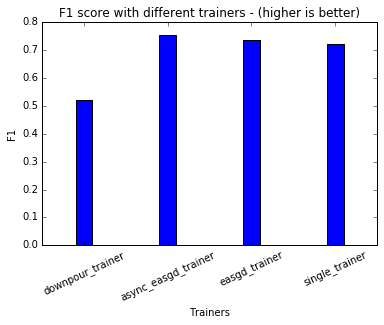

In [83]:
# Plot the F1 score of the trainers.
plt.bar(range(len(results)), results.values(), 0.2, align='center', color='b')
plt.xticks(range(len(results)), results.keys(), rotation=25)
plt.xlabel('Trainers')
plt.ylabel('F1')
plt.title("F1 score with different trainers - (higher is better)")
plt.show()

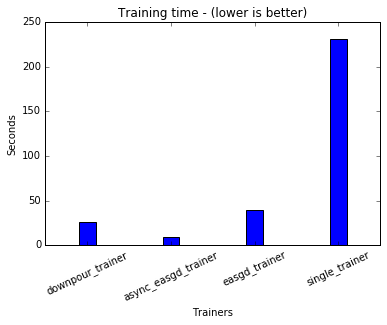

In [84]:
# Plot the training time of the trainers.
plt.bar(range(len(time_spent)), time_spent.values(), 0.2, align='center', color='b')
plt.xticks(range(len(time_spent)), time_spent.keys(), rotation=25)
plt.xlabel('Trainers')
plt.ylabel('Seconds')
plt.title("Training time - (lower is better)")
plt.show()

### Observations

Of course, this is not a representative evaluation since distributed algorithms really benefit when the number of parallel trainers is a lot higher. In order to evaluate correctly, we must set up an experiment which will be able to make a clear picture. First, we will include training time, and run the experiments multiple times using a different number of workers. Then, we will also evaluate the different batch_sizes, since this will influence the communication periods, and gradient residuals. Furthermore, we will also examine the learning rate.

**Note 1**: It would be nice to obtain the aggregated loss of all the trainers. However, this is not *yet* possible in Distributed Keras.

**Note 2**: In this experiment we will iterate over the number of **POSSIBLE** parallel trainers. If your cluster allows for more CPU cores to be used, you will obtain different results compared to a system with less CPU cores.

### Advanced evaluation

TODO